In [1]:
from functools import reduce
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage.transform import resize  # %pip install scikit-image

/home/alvar258/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download dataset.
path = kagglehub.dataset_download("qingyi/wm811k-wafer-map")
LSWMD_path = os.path.join(path, "LSWMD.pkl")
print(LSWMD_path)

/home/alvar258/.cache/kagglehub/datasets/qingyi/wm811k-wafer-map/versions/1/LSWMD.pkl


In [3]:
# Load data in pandas dataframe.
df = pd.read_pickle(LSWMD_path)

In [4]:
# Drop empty failures.
print(f"Original data size: {df.shape}")
df = df[df["failureType"] != ""]
print(f"Data size after dropping unlabel data: {df.shape}")

# Change failure type from [[np.str_]] to np.str_
df["failureType"] = df["failureType"].apply(
    lambda x: x[0][0] if x.shape != (0, 0) else ""
)

# Drop train/test label.
df = df.drop(columns=["trianTestLabel"]).reset_index(drop=True)

Original data size: (811457, 6)
Data size after dropping unlabel data: (172950, 6)


In [5]:
# Not all wafer maps has equal size. So, explore the images shape.

imgShapes = np.array([shape for shape in df["waferMap"].apply(lambda x: x.shape)])

row_min = np.argmin(imgShapes[:, 0])
col_min = np.argmin(imgShapes[:, 1])
if imgShapes[row_min, 0] < imgShapes[col_min, 1]:
    idxMin = row_min
else:
    idxMin = col_min
print(f"idxMin = {idxMin}, shape = {imgShapes[idxMin]}")

row_max = np.argmax(imgShapes[:, 0])
col_max = np.argmax(imgShapes[:, 1])
if imgShapes[row_max, 0] > imgShapes[col_max, 1]:
    idxMax = row_max
else:
    idxMax = col_max
print(f"idxMax = {idxMax}, shape = {imgShapes[idxMax]}")

mul_max = np.argmax(imgShapes[:, 0] * imgShapes[:, 1])
print(f"mul_max = {mul_max}, shape = {imgShapes[mul_max]}")

# Avg for image shape.
avgShape = tuple(sum(col) / len(col) for col in zip(*imgShapes))
print(f"avgImgShape={avgShape}")

idxMin = 109448, shape = [15  3]
idxMax = 10419, shape = [212  84]
mul_max = 15063, shape = [153 187]
avgImgShape=(np.float64(35.23280716970223), np.float64(34.82212778259613))


Failure type: none


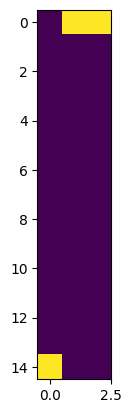

In [6]:
y = df["failureType"][idxMin]
print(f"Failure type: {y}")
plt.imshow(df["waferMap"][idxMin])

Failure type: Loc


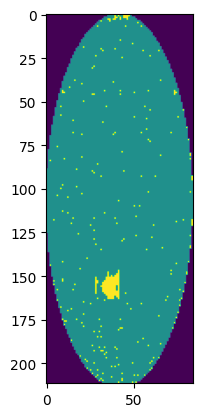

In [7]:
y = df["failureType"][idxMax]
print(f"Failure type: {y}")
plt.imshow(df["waferMap"][idxMax])

In [8]:
# Remove images that has at least one shape with less than 18 pixels.

print(f"Org # of samples: {df.shape[0]}")
df = df[~np.logical_or(imgShapes[:, 0] < 18, imgShapes[:, 1] < 18)].reset_index(drop=True)
print(f"New # of samples: {df.shape[0]}")

Org # of samples: 172950
New # of samples: 172946


In [9]:
# Not all wafer maps has equal size. So, explore the images shape.

imgShapes = np.array([shape for shape in df["waferMap"].apply(lambda x: x.shape)])

row_min = np.argmin(imgShapes[:, 0])
col_min = np.argmin(imgShapes[:, 1])
if imgShapes[row_min, 0] < imgShapes[col_min, 1]:
    idxMin = row_min
else:
    idxMin = col_min
print(f"idxMin = {idxMin}, shape = {imgShapes[idxMin]}")

row_max = np.argmax(imgShapes[:, 0])
col_max = np.argmax(imgShapes[:, 1])
if imgShapes[row_max, 0] > imgShapes[col_max, 1]:
    idxMax = row_max
else:
    idxMax = col_max
print(f"idxMax = {idxMax}, shape = {imgShapes[idxMax]}")

idxMin = 11769, shape = [40 18]
idxMax = 10419, shape = [212  84]


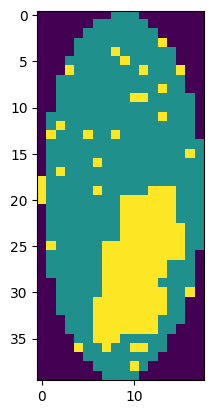

In [10]:
plt.imshow(df["waferMap"][idxMin])

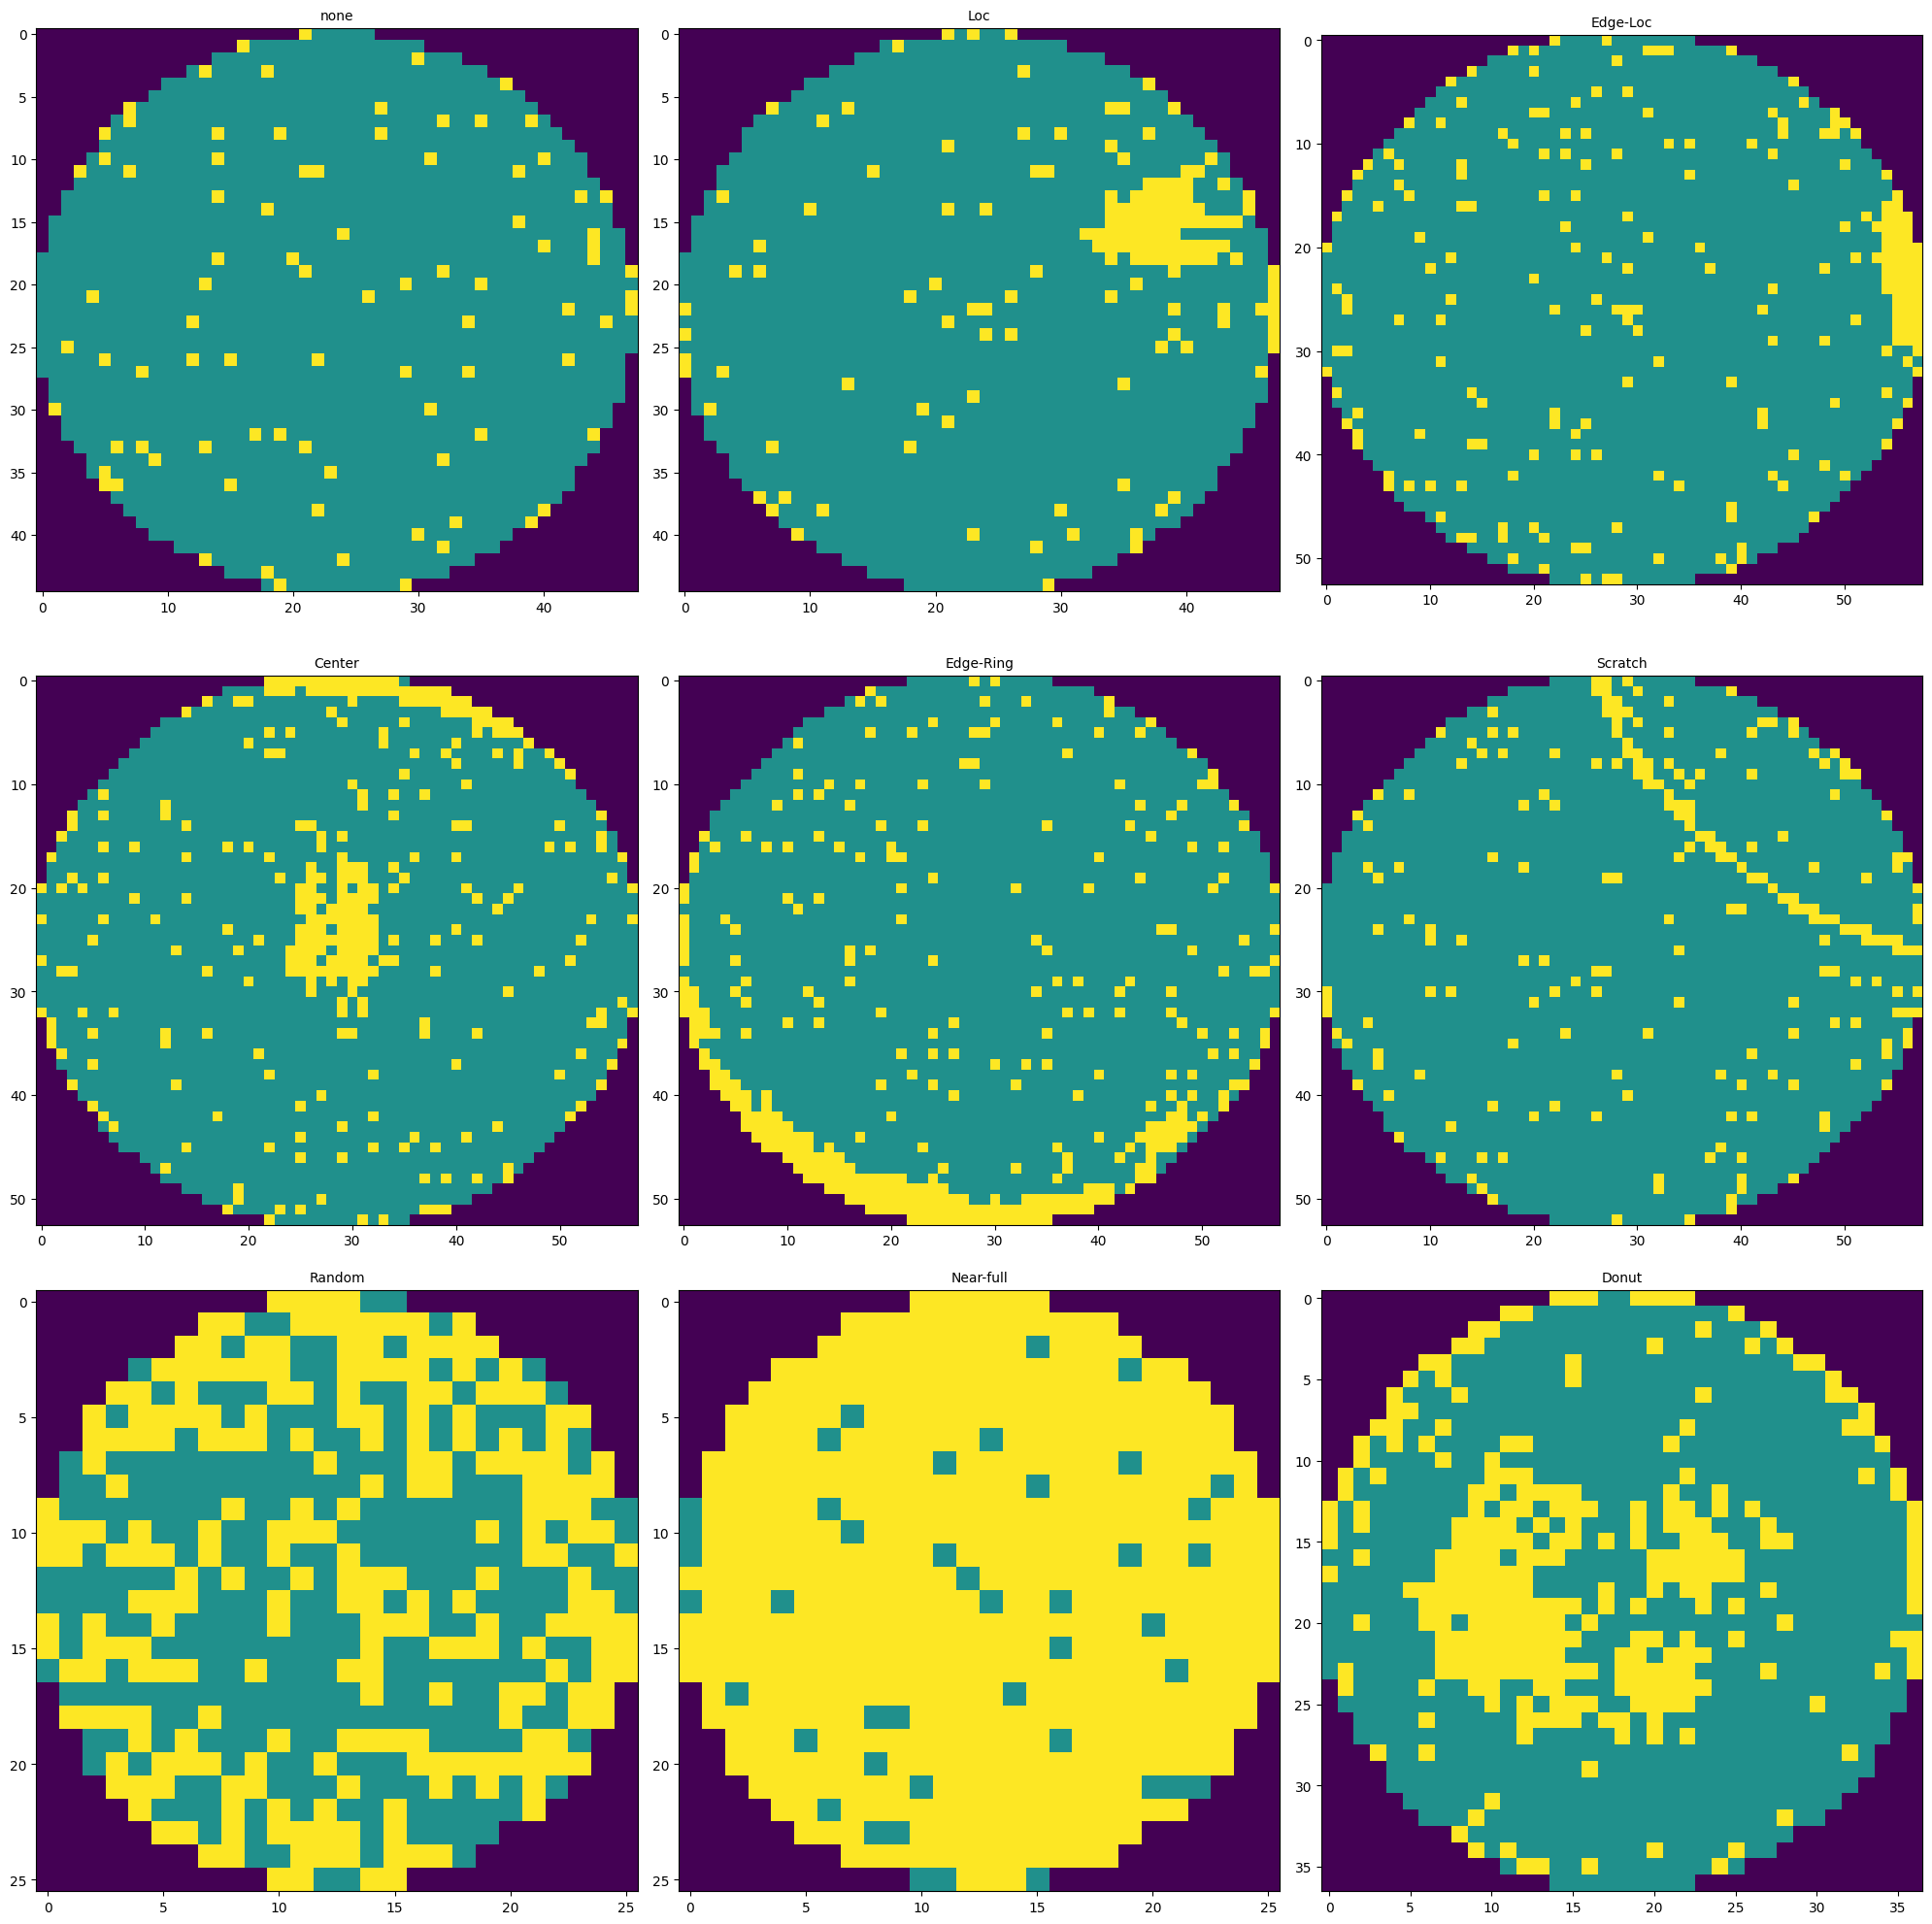

In [11]:
# Plot a wafer map.

_, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
ax = ax.ravel(order="C")

for i, failureType in enumerate(df["failureType"].unique()):
    exampleIdx = df["failureType"][df["failureType"] == failureType].index[0]

    ax[i].imshow(df.iloc[exampleIdx]["waferMap"])
    ax[i].set_title(failureType, fontsize=10)
plt.tight_layout()
plt.show()

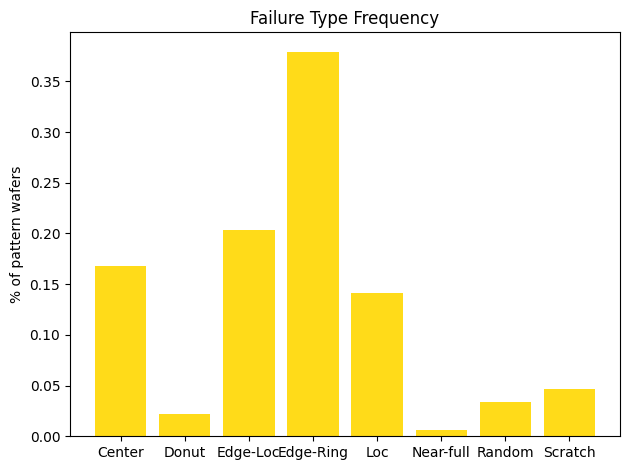

# of examples w/ failure: 147427
# of examples w/o failure: 25519


In [12]:
# Bar chart to see failure type balance.
df_w_failure = df[df["failureType"] != "none"]

x_vals, y_vals = np.unique(df_w_failure["failureType"], return_counts=True)
y_vals = y_vals / df_w_failure.shape[0]

labels2 = [
    "Center",
    "Donut",
    "Edge-Loc",
    "Edge-Ring",
    "Loc",
    "Random",
    "Scratch",
    "Near-full",
]

# Plot bars.
plt.bar(x_vals, y_vals, color="gold", align="center", alpha=0.9)

# Labels and styling.
plt.title("Failure Type Frequency")
plt.ylabel("% of pattern wafers")
plt.tick_params(axis="y")
plt.tight_layout()
plt.show()

print(f"# of examples w/ failure: {df[df['failureType'] == 'none'].shape[0]}")
print(f"# of examples w/o failure: {df_w_failure.shape[0]}")

In [13]:
tot = df.shape[0]
good_samples = df[df["failureType"] == "none"].shape[0]
bad_samples = tot - good_samples

print(f"tot = {tot}, good = {good_samples}, bad = {bad_samples}")

tot = 172946, good = 147427, bad = 25519


In [14]:
# Map non-faulty samples to 0, faulty to 1
df["failureNum"] = np.where(df["failureType"] == "none", 0, 1)

# Extract data.
X = df["waferMap"].to_numpy()
Y = df["failureNum"].to_numpy(dtype=np.uint8)

# Resize to nsize-by-nsize using nearest-neighbor.
nsize = 36  # Round up value of average shape.
resizef = lambda x: resize(
    x, (nsize, nsize), order=0, preserve_range=True, anti_aliasing=False
).astype(np.uint8)
X = np.array([resizef(x) for x in X])

row_max = 10419, shape = [212  84]
col_max = 15031, shape = [122 204]
imgIdx = 10419
y = Loc
shape = (212, 84)


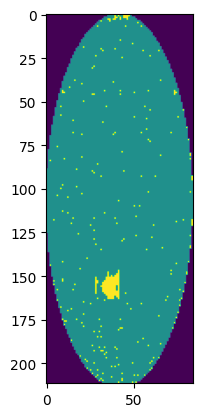

In [15]:
# Plot largest image.

imgShapes = np.array([shape for shape in df["waferMap"].apply(lambda x: x.shape)])
 
row_max = np.argmax(imgShapes[:, 0])
print(f"row_max = {row_max}, shape = {imgShapes[row_max]}")
col_max = np.argmax(imgShapes[:, 1])
print(f"col_max = {col_max}, shape = {imgShapes[col_max]}")

if imgShapes[row_max, 0] > imgShapes[col_max, 1]:
    idxMax = row_max
else:
    idxMax = col_max

print(f"imgIdx = {idxMax}")
y = df["failureType"][idxMax]
print(f"y = {y}")
x1 = df["waferMap"][idxMax]
print(f"shape = {x1.shape}")
plt.imshow(x1)

shape = (36, 36)


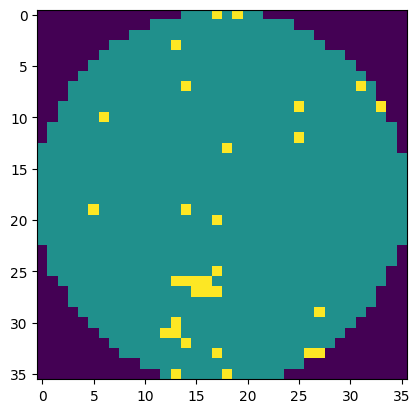

In [16]:
# Plot largest image.

x0 = X[idxMax]
print(f"shape = {x0.shape}")
plt.imshow(x0)

In [ ]:
# 85% of the data has no fault, but 15% does.
#   So, some synthetic fault data would be generated by applying 2 random rotations to faulty examples.

# Define transformations.
transformations = [
    lambda image: np.rot90(image, k=1),  # rotate 90 degrees
    lambda image: np.rot90(image, k=2),  # rotate 180 degrees
    lambda image: np.flipud(image),  # reflect over x-axis
    lambda image: np.fliplr(image),  # reflect over y-axis
]


def apply_random_transforms(img, n: int) -> np.ndarray:
    funcs = random.sample(transformations, n)
    return reduce(lambda acc, f: f(acc), funcs, img)


new_images = [
    apply_random_transforms(img, (i % 2) + 1)
    for i, img in enumerate(X[df["failureNum"] == 1])
]

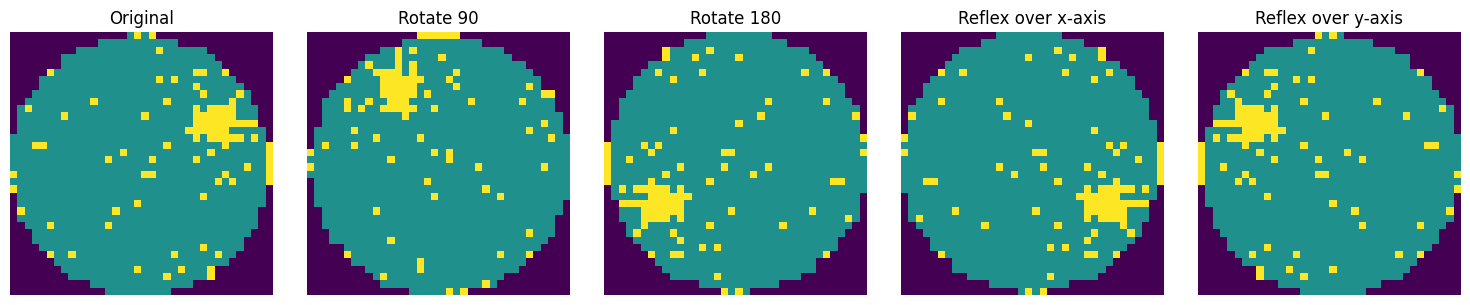

In [25]:
img_t = X[df["failureNum"] == 1][0]

# Titles for each subplot.
titles = ["Original", "Rotate 90", "Rotate 180", "Reflex over x-axis", "Reflex over y-axis"]

# Apply transformations.
images = [img_t] + [func(img_t) for func in transformations]

# Plotting.
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [23]:
# Expand X and Y.
k = len(new_images)
n = X.shape[0]

X = np.concatenate((X, new_images), axis=0)
Y = np.concatenate((Y, np.ones(k, dtype=np.uint8)), axis=0)

# Save X and Y into a df.
org = np.concatenate([np.ones(n, dtype=bool), np.zeros(k, dtype=bool)])
dataset_df = pd.DataFrame({"X": list(X), "Y": Y, "org": org})

In [12]:
# Save new dataframe.
save_df = False

if save_df:
    dir_path = "data"
    fname = "LSWMD_dataset.pkl"

    os.makedirs(dir_path, exist_ok=True)
    dataset_df.to_pickle(os.path.join(dir_path, fname))